# Network Topology
Using QGIS

(데이터 어떤거 사용했는지 싹 정리)

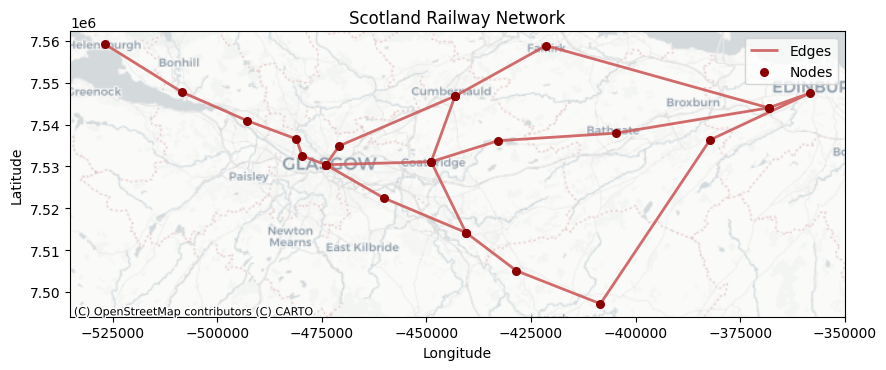

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import pandas as pd


# Define file paths
toy_node_path = r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\QGIS\QGISshp\Scotland_node_data.shp"
toy_edge_path = r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\QGIS\QGISshp\Scotland_edge_data.shp"

# Load the shapefiles
toy_node = gpd.read_file(toy_node_path)
toy_edge = gpd.read_file(toy_edge_path)

# Convert CRS to Web Mercator (EPSG:3857) for basemap compatibility
toy_edge = toy_edge.to_crs(epsg=3857)
toy_node = toy_node.to_crs(epsg=3857)

# Create a plot with network and basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges and nodes
toy_edge.plot(ax=ax, color="indianred", linewidth=2, alpha=0.9, label="Edges", zorder=1)
toy_node.plot(ax=ax, color="darkred", markersize=30, label="Nodes", zorder=2)

# Add a basemap from Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=0)

plt.legend()
plt.title("Scotland Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Nodes
n1: (-526743.9326977674, 7559191.047008602)
n2: (-508433.02285110863, 7547787.179290685)
n3: (-492770.94734187395, 7540915.577303931)
n4: (-481058.8356108721, 7536566.09327646)
n5: (-479690.78206530923, 7532536.382650457)
n6: (-474003.90093657264, 7530406.725499618)
n7: (-470848.7340172999, 7534904.792664699)
n8: (-460120.2099542361, 7522438.511371442)
n9: (-448851.26344105584, 7531134.767801062)
n10: (-443145.7676481675, 7546818.836540823)
n11: (-440545.8355925146, 7514209.841210318)
n12: (-432817.4774551757, 7536151.651174133)
n13: (-428455.99388436903, 7505072.666500858)
n14: (-421396.41021384794, 7558889.676746716)
n15: (-408396.38156367984, 7497188.819354335)
n16: (-404773.35276562383, 7537954.068966589)
n17: (-382215.06639498885, 7536339.935614771)
n18: (-368205.76442648796, 7544009.876788179)
n19: (-358352.66333297483, 7547526.255708998)

Edges (Properly Ordered & Bidirectional):
e1: n1 → n2
e2: n2 → n1
e3: n2 → n3
e4: n3 → n2
e5: n3 → n4
e6: n4 → n3
e7: n4 → n5
e8: n5 → n

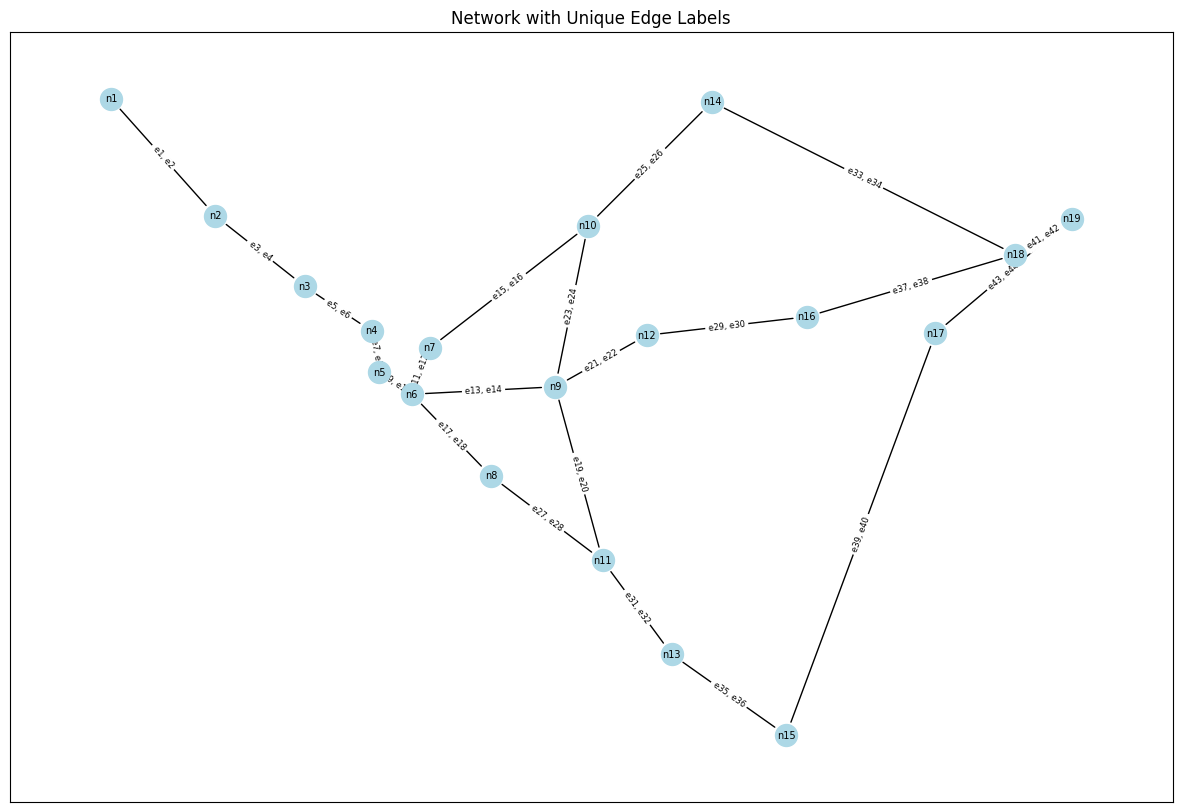

In [7]:
import networkx as nx



# 1. Node numbering (n1, n2, ...)
unique_coords = list(set((row.geometry.x, row.geometry.y) for row in toy_node.itertuples()))
sorted_coords = sorted(unique_coords, key=lambda coord: (coord[0], -coord[1]))

nodes = {f"n{i+1}": coord for i, coord in enumerate(sorted_coords)}

print("Nodes")
for node_name, coords in nodes.items():
    print(f"{node_name}: {coords}")



# 2. Edge numbering (e1, e2, ...)
unique_coords = list(set((row.geometry.x, row.geometry.y) for row in toy_node.itertuples())) # Extract unique coordinates (remove duplicates)
sorted_coords = sorted(unique_coords, key=lambda coord: (coord[1], -coord[0])) # Sort coordinates: First by Y (ascending), then by X (descending)

coord_to_node = {coord: node for node, coord in nodes.items()}

# Collect edges into a list (before sorting)
edge_list = []

for _, row in toy_edge.iterrows():
    line: LineString = row.geometry  
    coords = list(line.coords)  # Extract coordinates from LINESTRING

    for i in range(len(coords) - 1):
        start_coord = coords[i]
        end_coord = coords[i + 1]

        # Match coordinates with nodes
        start_node = coord_to_node.get(start_coord)
        end_node = coord_to_node.get(end_coord)

        if start_node and end_node:
            edge_list.append((start_node, end_node))

edge_list = sorted(edge_list, key=lambda edge: (int(edge[0][1:]), int(edge[1][1:]))) # Sort edges by smallest starting node number

# Create bidirectional edges with correct numbering
edges = {}
arc_id = 1  

for start_node, end_node in edge_list:
    edges[f"e{arc_id}"] = (start_node, end_node)   # Forward edge
    edges[f"e{arc_id+1}"] = (end_node, start_node) # Reverse edge
    arc_id += 2  # Increment by 2 (to maintain odd-even numbering)

print("\nEdges (Properly Ordered & Bidirectional):")
for edge_name, (start_node, end_node) in edges.items():
    print(f"{edge_name}: {start_node} → {end_node}")



# 3. Convert edges to arc format
arcs = [(u, v) for _, (u, v) in edges.items()]



# 4. Compute Euclidean distances
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)

arc_distance = {edge_name: euclidean_distance(u, v) for edge_name, (u, v) in edges.items()}

print("Arc Distances:", arc_distance)



# 5. Create a network graph
# Create the graph using extracted data
G = nx.DiGraph()

# Add nodes and edges
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_name, (u, v) in edges.items(): 
    G.add_edge(u, v, weight=arc_distance[edge_name])

# Remove duplicate edges
unique_edges = set()
edge_name_map = {}

for edge_name, (u, v) in edges.items():
    if (v, u) not in unique_edges:  
        unique_edges.add((u, v))
        reverse_edge_name = [k for k, (a, b) in edges.items() if (a, b) == (v, u)]  
        if reverse_edge_name:
            edge_label = f"{edge_name}, {reverse_edge_name[0]}"  
        else:
            edge_label = edge_name  
        
        edge_name_map[(u, v)] = edge_label  

# Plot the network topology
plt.figure(figsize=(15, 10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=250, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(unique_edges),  
    arrowstyle='-',
    min_target_margin=10,
    min_source_margin=10
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_name_map, font_size=6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Network with Unique Edge Labels")
plt.show()

# Basic Settings
Generate Random Arc Capacity Value

In [8]:
import sys
import os
sys.path.append(r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\BNS-JT-python")

import re 
import json
import gc  
import copy

import numpy as np
from gurobipy import Model, GRB, quicksum

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

import BNS_JT.brc as brc
import BNS_JT.cpm as cpm
import BNS_JT.variable as variable
import BNS_JT.operation as operation
import BNS_JT.branch as branch
import batch

gc.collect()  # memory clean-up
%matplotlib inline

In [9]:
nodes = nodes  
edges = edges  
arcs = arcs
arc_distance = arc_distance 



# 1. Generate arc failure probabilities based on arc distances (longer distance -> higher failure probability)
# Get the minimum and maximum arc distances
min_dist = min(arc_distance.values())
max_dist = max(arc_distance.values())

# Failure probability range (0.01 ~ 0.1)
min_prob = 0.01
max_prob = 0.1

def compute_failure_probability(distance, min_dist, max_dist, min_prob, max_prob):
    normalized_dist = (distance - min_dist) / (max_dist - min_dist)  # Normalize to [0,1]
    return round(min_prob + normalized_dist * (max_prob - min_prob), 4)

# Generate failure probability for each edge
probs_dynamic = {
    edge: {
        0: compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 
        1: round(1 - compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 4)
    }
    for edge, dist in arc_distance.items()
}

# Sort edges by numeric order
def numeric_sort(edge):
    return int(edge[1:])  # Extract numeric part from "eX"

probs_sorted = {k: probs_dynamic[k] for k in sorted(probs_dynamic, key=numeric_sort)}

# Print formatted probabilities
print(json.dumps(probs_sorted, indent=4, separators=(",", ": ")))
probs = probs_sorted
probs_cpm = copy.deepcopy(probs)
print(probs_cpm)



# 2. Assign capacities to each arcs
# Initial intact capacity (Unchanged from original)
reduced_capacity_edges = {"e10", "e12", "e20", "e21",
                          "e25", "e26", "e42", "e43"}

intact_capacity = {edge: 35 if edge in reduced_capacity_edges else 40 for edge in edges}

# Function to generate random component states (0 or 1) based on failure probabilities
def generate_comps_st(probs):
    comps_st = {}

    for edge, prob in probs.items():
        if isinstance(prob, dict) and 0 in prob and 1 in prob:  # Ensure correct structure
            comps_st[edge] = np.random.choice([0, 1], p=[prob[0], prob[1]])
        else:
            print(f"Warning: Invalid probability format for edge {edge}: {prob}")  # Debugging message

    return comps_st

# Compute arc capacities
comps_st = generate_comps_st(probs_sorted)  # Use directly without JSON conversion
arc_capacity = {edge: int(intact_capacity[edge] * comps_st[edge]) for edge in intact_capacity}

print(json.dumps(arc_capacity, indent=4, separators=(",", ": ")))



# 3. Compute maximum allowable distance
# Demand data
demand = {
    "k1": {"origin": "n10", "destination": "n13", "amount": 32},
    "k2": {"origin": "n2", "destination": "n12", "amount": 34},
    "k3": {"origin": "n10", "destination": "n8", "amount": 15},
    "k4": {"origin": "n7", "destination": "n18", "amount": 35},
    "k5": {"origin": "n17", "destination": "n12", "amount": 40},
    "k6": {"origin": "n18", "destination": "n12", "amount": 49},
    "k7": {"origin": "n19", "destination": "n15", "amount": 42},
    "k8": {"origin": "n10", "destination": "n4", "amount": 49},
    "k9": {"origin": "n16", "destination": "n12", "amount": 43},
    "k10": {"origin": "n10", "destination": "n1", "amount": 17},
    "k11": {"origin": "n3", "destination": "n1", "amount": 30},
    "k12": {"origin": "n4", "destination": "n15", "amount": 38}
}

# Compute max allowable distance
avg_velo = 149  # Speed in km/h
max_distance = {}

for commodity, info in demand.items():
    shortest_distance = nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight')
    max_allowable_time = (shortest_distance * 60) / avg_velo + 4500  # 9000 minutes extra
    max_distance[commodity] = max_allowable_time * avg_velo / 60  # Store per commodity

    print(f"\nCommodity: {commodity}")
    print(f"  Shortest distance: {shortest_distance} km")
    print(f"  Maximum allowable time: {max_allowable_time:.2f} minutes")
    print(f"  Maximum allowable distance: {max_distance[commodity]:.2f} km")

{
    "e1": {
        "0": 0.0406,
        "1": 0.9594
    },
    "e2": {
        "0": 0.0406,
        "1": 0.9594
    },
    "e3": {
        "0": 0.0327,
        "1": 0.9673
    },
    "e4": {
        "0": 0.0327,
        "1": 0.9673
    },
    "e5": {
        "0": 0.0245,
        "1": 0.9755
    },
    "e6": {
        "0": 0.0245,
        "1": 0.9755
    },
    "e7": {
        "0": 0.01,
        "1": 0.99
    },
    "e8": {
        "0": 0.01,
        "1": 0.99
    },
    "e9": {
        "0": 0.0132,
        "1": 0.9868
    },
    "e10": {
        "0": 0.0132,
        "1": 0.9868
    },
    "e11": {
        "0": 0.0122,
        "1": 0.9878
    },
    "e12": {
        "0": 0.0122,
        "1": 0.9878
    },
    "e13": {
        "0": 0.0469,
        "1": 0.9531
    },
    "e14": {
        "0": 0.0469,
        "1": 0.9531
    },
    "e15": {
        "0": 0.0557,
        "1": 0.9443
    },
    "e16": {
        "0": 0.0557,
        "1": 0.9443
    },
    "e17": {
        "0": 0.0307,
     

In [10]:
varis = {}
for k, v in edges.items():
    varis[k] = variable.Variable( name=k, values = [0, 1]) # values: edge flow capacity

### Demand required for the network topology

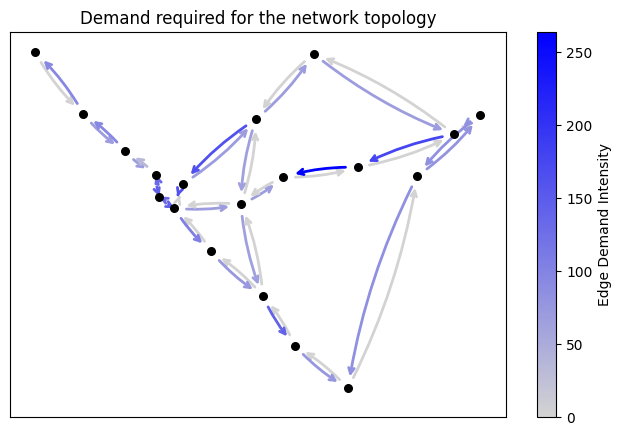

In [11]:
# Compute total demand separately for each edge 
edge_demand = {edge: 0 for edge in edges.keys()}

# Create mapping for bidirectional edges 
bidirectional_mapping = {}
edge_list = list(edges.keys())

for i in range(0, len(edge_list), 2):
    if i + 1 < len(edge_list):
        bidirectional_mapping[edge_list[i]] = edge_list[i + 1]
        bidirectional_mapping[edge_list[i + 1]] = edge_list[i]

# Sum up demand for edges used in any shortest path (all possible shortest paths)
for demand_key, info in demand.items():
    origin, destination, amount = info["origin"], info["destination"], info["amount"]
    try:
        all_paths = list(nx.all_shortest_paths(G, source=origin, target=destination, weight="weight"))
        
        for path in all_paths:
            for i in range(len(path) - 1):
                path_edge = (path[i], path[i + 1])
                for edge_name, (u, v) in edges.items():
                    if path_edge == (u, v):  # Forward direction
                        edge_demand[edge_name] += amount  
                    elif path_edge == (v, u):  # Backward direction
                        reverse_edge = bidirectional_mapping.get(edge_name, edge_name)
                        edge_demand[reverse_edge] += amount  
    except nx.NetworkXNoPath:
        pass  # Ignore cases where no path exists

# Normalize demand values with a small shift (epsilon) to prevent 0
D_max = max(edge_demand.values()) if max(edge_demand.values()) > 0 else 1  # Prevent division by zero
D_min = min(edge_demand.values()) if min(edge_demand.values()) > 0 else 0
epsilon = 0.1  # Small shift to prevent 0 values

normalized_demand = {
    edge: (demand - D_min + epsilon) / (D_max - D_min + epsilon) if D_max != D_min else 0.5
    for edge, demand in edge_demand.items()
}

# Create custom colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("gray_to_blue", ["lightgray", "blue"])

# Create NetworkX graph
G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)
for edge_name, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_distance[edge_name], label=edge_name)
pos = nx.get_node_attributes(G, "pos")

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_frame_on(True)  # Ensure plot box is visible
nx.draw_networkx_nodes(G, pos, node_size=30, node_color="black", ax=ax)
drawn_edges = set()  # To avoid duplicate plotting

for edge_name, (u, v) in edges.items():
    if edge_name in drawn_edges:
        continue  # Skip if already drawn

    color = cmap(normalized_demand[edge_name])

    # Forward direction (u -> v)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=2,
        edge_color=[color], edge_cmap=cmap,
        arrowstyle="->", arrowsize=10,
        alpha=1, ax=ax, connectionstyle="arc3,rad=0.08"
    )

    # Reverse direction (v -> u)
    reverse_edge = bidirectional_mapping.get(edge_name, edge_name)
    if reverse_edge != edge_name:  # Ensure backward edge exists
        color_reverse = cmap(normalized_demand[reverse_edge])
        nx.draw_networkx_edges(
            G, pos, edgelist=[(v, u)], width=2,
            edge_color=[color_reverse], edge_cmap=cmap,
            arrowstyle="->", arrowsize=10,
            alpha=1, ax=ax, connectionstyle="arc3,rad=0.08"
        )

    # Mark both forward and backward edges as drawn
    drawn_edges.add(edge_name)
    drawn_edges.add(reverse_edge)

# Colorbar setup
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=D_min, vmax=D_max))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Edge Demand Intensity")
plt.title("Demand required for the network topology")
plt.show()

# MCNF System Function

By using Gurobi solver

연결성만으로 시스템이 생존(sys_st = 's')한다고 평가하지 않고, 기대 손실(expected_loss)이 기준 이하일 때만 생존으로 간주
그렇다면 최소 생존 상태(min_comps_st)는 단순히 "연결만 되는 상태"를 의미하는 것이 아니라, "손실을 최소화하면서 운영이 가능한 상태"여야 함

In [12]:
def MCNF_systemfunc(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance):
    from gurobipy import Model, GRB, quicksum
    import networkx as nx

    # Create a graph for shortest path calculations
    G = nx.Graph()
    for e, (i, j) in edges.items():
        G.add_edge(i, j, weight=arc_distance.get(e, 1))  # Set edge weights based on distance

    # Create Gurobi optimization model
    model = Model("Network Flow Optimization")
    model.setParam('OutputFlag', 0) 

    # Define variables
    flow = {}
    unmet_demand = {}

    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
            capacity = arc_capacity.get(arc_key, 0)
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize expected loss
    cost_coefficient = {
        k: info['amount'] * nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight') * 0.1723
        for k, info in demand.items()
    }
    
    model.setObjective(
        quicksum(cost_coefficient[k] * unmet_demand[k] for k in demand),
        GRB.MINIMIZE
    )

    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == - amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
        model.addConstr(quicksum(flow[k, i, j] for k in demand if (k, i, j) in flow) <= arc_capacity.get(arc_key, 0))

    # Constraint 3: Commodity별 max_distance 적용
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get(e, 0) * flow[k, i, j] for e, (i, j) in edges.items() if (k, i, j) in flow)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if (k, i, j) in flow and i == origin)
        
        # max_distance를 dictionary에서 해당 commodity에 맞게 참조
        model.addConstr(distance_expr <= max_distance[k] * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        expected_loss = model.objVal

        if expected_loss < 89000000:
            sys_st = 's'

            # We can infer an associated minimum survival rule in case of network connectivity.
            min_comps_st = {}

            # Extract used links from optimization result
            for (k, i, j), var in flow.items():
                if var.x > 0:  # If flow is greater than 0, the edge is used in the solution
                    link_name = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
                    if link_name:
                        min_comps_st[link_name] = 1  # Store as {e1: 1, e2: 1}

        else:
            sys_st = 'f'
            min_comps_st = None  # No survival rule needed for failed state

        return expected_loss, sys_st, min_comps_st  

    else:
        return None, None, None  


Run MCNF system function

In [13]:
sys_fun = lambda comps_st: MCNF_systemfunc(
    arcs=arcs,
    comps_st=comps_st, 
    edges=edges,
    arc_capacity={edge: intact_capacity[edge] * comps_st[edge] for edge in intact_capacity},  
    demand=demand,
    max_distance=max_distance, 
    arc_distance=arc_distance
)


# Print input values
print("\n🔹 Input Values:")
print("Component States (comps_st):", comps_st)
print("Edges:", edges)
print("Arc Capacity:", arc_capacity)
print("Demand:", demand)
print("Max Distance:", max_distance)
print("Arc Distance:", arc_distance)

# Run the function and capture outputs
expected_loss, sys_st, min_comps_st = sys_fun(comps_st)

# Print output values
print("\n🔹 Output Values:")
print("System State:", sys_st)
print("Minimum component state:", min_comps_st) 


🔹 Input Values:
Component States (comps_st): {'e1': np.int64(1), 'e2': np.int64(1), 'e3': np.int64(1), 'e4': np.int64(1), 'e5': np.int64(1), 'e6': np.int64(1), 'e7': np.int64(1), 'e8': np.int64(1), 'e9': np.int64(1), 'e10': np.int64(1), 'e11': np.int64(1), 'e12': np.int64(1), 'e13': np.int64(1), 'e14': np.int64(1), 'e15': np.int64(1), 'e16': np.int64(1), 'e17': np.int64(1), 'e18': np.int64(1), 'e19': np.int64(0), 'e20': np.int64(1), 'e21': np.int64(1), 'e22': np.int64(1), 'e23': np.int64(1), 'e24': np.int64(1), 'e25': np.int64(1), 'e26': np.int64(1), 'e27': np.int64(1), 'e28': np.int64(1), 'e29': np.int64(1), 'e30': np.int64(1), 'e31': np.int64(1), 'e32': np.int64(1), 'e33': np.int64(1), 'e34': np.int64(1), 'e35': np.int64(0), 'e36': np.int64(1), 'e37': np.int64(0), 'e38': np.int64(1), 'e39': np.int64(1), 'e40': np.int64(1), 'e41': np.int64(1), 'e42': np.int64(1), 'e43': np.int64(1), 'e44': np.int64(1)}
Edges: {'e1': ('n1', 'n2'), 'e2': ('n2', 'n1'), 'e3': ('n2', 'n3'), 'e4': ('n3', '

# Expected Loss Evaluation
By BRC algorithm

In [14]:
# Run BRC with stopping criteria (max_rules = 100)
brs, rules, sys_res, monitor = brc.run(
    varis=varis, 
    probs=probs, 
    sys_fun=sys_fun, 
    max_sf=np.inf, 
    max_nb=np.inf, 
    pf_bnd_wr=0.0, 
    max_rules=100,  
    brs=[]
)

# Check if BRC stopped due to max_rules
if len(rules['s'] + rules['f']) >= 100:
    print("\n🔹 BRC terminated because 100 rules have been found.")

# System failure probability
P_f = sum(branch.p for branch in brs if branch.down_state == 'f')
print(f"System Failure Probability (P_f): {P_f}")

# Identify unknown branches (brs_u)
brs_u = [branch for branch in brs if branch.down_state == 'u' or branch.up_state == 'u']

print(brs_u)
print(f"Number of unknown branches: {len(brs_u)}")

*** Analysis completed with f_sys runs 137: out_flag = max_rules ***
The # of found non-dominated rules (f, s): 100 (34, 66)
Probability of branchs (f, s, u): (7.7192e-02, 8.88e-01, 3.5071e-02)
The # of branches (f, s, u), (min, avg) len of rf: 643 (116, 94, 433), (2, 2.00)

🔹 BRC terminated because 100 rules have been found.
System Failure Probability (P_f): 0.07719190845680916
[Branch(
  down={'e1': 1, 'e2': 0, 'e3': 1, 'e4': 0, 'e5': 0, 'e6': 0, 'e7': 1, 'e8': 0, 'e9': 0, 'e10': 0, 'e11': 1, 'e12': 0, 'e13': 1, 'e14': 0, 'e15': 1, 'e16': 0, 'e17': 1, 'e18': 0, 'e19': 1, 'e20': 0, 'e21': 1, 'e22': 0, 'e23': 1, 'e24': 0, 'e25': 1, 'e26': 0, 'e27': 1, 'e28': 0, 'e29': 1, 'e30': 0, 'e31': 1, 'e32': 0, 'e33': 1, 'e34': 0, 'e35': 1, 'e36': 0, 'e37': 1, 'e38': 0, 'e39': 1, 'e40': 0, 'e41': 1, 'e42': 0, 'e43': 1, 'e44': 0},
  up={'e1': 1, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 0, 'e6': 1, 'e7': 1, 'e8': 1, 'e9': 0, 'e10': 1, 'e11': 1, 'e12': 1, 'e13': 1, 'e14': 1, 'e15': 1, 'e16': 1, 'e17': 1, 'e

In [15]:
print("\n🔹 Running Monte Carlo Simulation (MCS) after BRC termination.")

def sys_fun_rs(sample1):
    val, sys_st, _ = sys_fun(sample1)
    return val, sys_st

# Define system variable
varis['sys_event'] = variable.Variable(name='sys_event', values=['f', 's', 'u'])

cpms = {}  # Initialize CPMs

# Create CPMs for each component event
for k, v in edges.items():
    cpms[k] = cpm.Cpm(
        variables=[varis[k]], 
        no_child=1, 
        C=np.array([[0], [1]]),  # Define states (0: fail, 1: survive)
        p=np.array([probs[k][0], probs[k][1]])  # Assign probabilities
    )

# Generate system constraint matrix
Csys, varis = brc.get_csys(brs, varis, {'f': 0, 's': 1, 'u': 2})
Csys = np.array(Csys, dtype=np.int32)  # Ensure integer type

# Ensure "sys_event" exists in CPMs
if "sys_event" not in cpms:
    cpms["sys_event"] = cpm.Cpm(
        variables=[varis["sys_event"]] + [varis[e] for e in edges],
        no_child=1,
        C=np.zeros((1, len(edges) + 1), dtype=int),  # Initialize constraints matrix
        p=np.array([1.0])  # Set initial probability
    )

# Adjust constraint matrix dimensions if needed
expected_columns = len(cpms["sys_event"].variables)
actual_columns = Csys.shape[1]

if actual_columns != expected_columns:
    print(f"⚠ Warning: Adjusting Csys! Expected {expected_columns} columns, but got {actual_columns}.")
    if actual_columns > expected_columns:
        Csys = Csys[:, :expected_columns]  # Trim excess columns
    else:
        missing_cols = expected_columns - actual_columns
        extra_cols = np.full((Csys.shape[0], missing_cols), 0)  # Fill missing columns with 0
        Csys = np.hstack((Csys, extra_cols))

cpms["sys_event"].Cs = Csys  # Assign constraint matrix to CPMs


# Transform unknown branches for MCS
brs_u_transformed = [
    (
        b.down,
        b.up,
        round(float(b.p), 20),  # Convert probability to float and round
        b.down_state,
        b.up_state,
    )
    for b in brs_u
]

# Run Monte Carlo Simulation for unknown branches
cpms, mcs_result = batch.mcs_unknown(
    brs_u=brs_u_transformed,
    probs=probs,
    sys_fun_rs=sys_fun_rs,
    cpms=cpms,
    sys_name="sys_event",
    cov_t=0.01,  # Convergence threshold
    sys_st_monitor=0,  # System failure monitoring state
    sys_st_prob=round(P_f, 20),  # Round system failure probability
    rand_seed=1  # Set random seed for reproducibility
)

# Print MCS results
print(f"\n🔹 MCS Completed. Failure Probability (pf): {mcs_result['pf']:.10e}")
print(f"   - COV: {mcs_result['cov']:.4e}")
print(f"   - Confidence Interval: [{mcs_result['cint_low']:.10e}, {mcs_result['cint_up']:.10e}]")
print(f"   - Number of Samples: {mcs_result['nsamp']}")



🔹 Running Monte Carlo Simulation (MCS) after BRC termination.
brs_u_probs: [0.0001335254250588809, 9.144329762894953e-05, 8.11259504587217e-05, 9.433391347827847e-05, 7.115765020593118e-05, 8.403635617647271e-05, 5.846017813493574e-05, 5.033034356658095e-05, 7.830639083050613e-05, 4.549145770728665e-05, 0.00011023243060426542, 9.26345860295351e-05, 4.05031289730512e-05, 3.954422290427697e-05, 9.195991291197389e-05, 7.72791493140057e-05, 3.432399160750684e-05, 2.046644016996923e-05, 1.99044851752942e-05, 3.217645171146305e-05, 6.645907296302062e-05, 1.823767412781328e-05, 1.452135541881137e-05, 6.831915976702159e-05, 1.660504729183485e-05, 2.602024283809641e-05, 2.62815246988057e-05, 0.0005904883333962983, 2.064415960708474e-05, 0.0005760590269292586, 0.0005748665512764665, 0.0005562115463270896, 5.420363088953778e-05, 0.0005383411650233038, 0.000525390271427293, 2.095322781197365e-05, 0.0004987553562097406, 0.0004948874172066002, 0.00048647221233919695, 0.0004758255078287036, 4.661319

In [16]:
sys_event_cpm = cpms.get("sys_event")

if sys_event_cpm:
    print("\n🔹 sys_event 변수 정보:")
    print(f"  - Variables: {[v.name for v in sys_event_cpm.variables]}")

    Csys = sys_event_cpm.Cs  # Constraints Matrix
    probs = sys_event_cpm.q  # Probabilities
    sample_idx = sys_event_cpm.sample_idx  # Sample Index

    num_samples = Csys.shape[0]
    num_vars = Csys.shape[1] 

    print("\n🔹 [Sample Index] [C (Constraints Matrix)] [p (Probabilities)]")

    for i in range(num_samples):
        C_row = " ".join(map(str, Csys[i])) 
        p_value = f"{probs[i][0]:.5e}"
        print(f"[{sample_idx[i][0]}] [{C_row}] , {p_value}")

else:
    print("\n⚠ `sys_event` 변수가 cpms에 존재하지 않습니다.")


🔹 sys_event 변수 정보:
  - Variables: ['sys_event', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25', 'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35', 'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44']

🔹 [Sample Index] [C (Constraints Matrix)] [p (Probabilities)]
[0] [0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1] , 1.00000e+00
[1] [1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] , 1.00000e+00
[2] [0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1] , 1.00000e+00
[3] [1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1] , 1.00000e+00
[4] [1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1] , 1.00000e+00
[5] [0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 

# Component Importance Calculation

### Birnbaum's Importance Measure (BM)

The **Birnbaum Importance Measure (BM)** quantifies the sensitivity of system reliability $p_s$ to the reliability of a specific component $p_i$. It is defined as:

$$
BM_i = P(S = 1 \mid X_i = 1) - P(S = 1 \mid X_i = 0)
$$

where:

- $P(S = 1 \mid X_i = 1)$ is the probability that the system functions given that component $X_i$ is functional.
- $P(S = 1 \mid X_i = 0)$ is the probability that the system functions given that component $X_i$ has failed.

This measure helps in assessing how much the reliability of an individual component influences the overall system reliability.


In [17]:
import importlib
import batch

importlib.reload(batch)

def sys_fun_rs(sample):
    val, sys_st, _ = sys_fun(sample)
    return val, sys_st

$$
P(S = 1 \mid X_i = 1)
$$

In [18]:
# Dictionary to store final results for each component
final_results = {}

# Iterate over all components in probs_cpm
for X_n in probs_cpm.keys():  
    print(f"... Computing for Component: {X_n}")

    # Step 1: Filter branches and apply system function (using P(X_n=1))
    survival_known_branch1, unknown_branch1 = batch.eventspace_x1_filter(brs_u, X_n, probs_cpm[X_n][1], sys_fun)

    # Step 2: Compute probabilities
    total_prob_survival1 = batch.compute_total_probability(survival_known_branch1)
    total_prob_unknown1 = batch.compute_total_probability(unknown_branch1)
    P_Xi_1 = probs_cpm[X_n][1]  # Extract P(X_i=1) from probs_cpm

    # Step 3: Compute P(S=1, X_i=1) from known branches
    B_s = [branch for branch in brs if branch.down_state == 's']
    brc_survival_prob1 = batch.survivalprob_xi1_brc100(brc_branches=B_s, probs=probs_cpm, target_xi=X_n)

    # Step 4: Run Monte Carlo Simulation (MCS) for unknown branches
    survival_prob1 = brc_survival_prob1 + total_prob_survival1

    mcs_result_unknown = batch.run_mcs_for_unknown_branch(
        brs_u=brs_u,
        unknown_branch=unknown_branch1, 
        probs=probs_cpm,  
        sys_fun_rs=sys_fun_rs, 
        cov_t=0.01,  
        sys_st_monitor=1,
        survival_prob=survival_prob1,
        rand_seed=None
    )

    # Compute conditional probability P(S=1 | X_i=1)
    P_S_given_Xi_1 = mcs_result_unknown['ps'] / P_Xi_1
    P_S_given_Xi_1_low = mcs_result_unknown['cint_low'] / P_Xi_1
    P_S_given_Xi_1_up = mcs_result_unknown['cint_up'] / P_Xi_1

    # Store results
    final_results[X_n] = {
        'P(X_i=1, S=1)': mcs_result_unknown['ps'],
        'P(S=1 | X_i=1)': P_S_given_Xi_1,
        'COV': mcs_result_unknown['cov'],
        'Confidence Interval': [P_S_given_Xi_1_low, P_S_given_Xi_1_up],
        'Number of Samples': mcs_result_unknown['nsamp']
    }

# Print final results for all components
print("\n🔹 **Final Conditional Probabilities for All Components** 🔹")
for comp, values in final_results.items():
    print(f"\nComponent: {comp}")
    print(f"   - Estimated P({comp}=1, S=1): {values['P(X_i=1, S=1)']:.10e}")
    print(f"   - Estimated P(S=1 | {comp}=1): {values['P(S=1 | X_i=1)']:.10e}")
    print(f"   - COV: {values['COV']:.4e}")
    print(f"   - Confidence Interval: [{values['Confidence Interval'][0]:.10e}, {values['Confidence Interval'][1]:.10e}]")
    print(f"   - Number of Samples: {values['Number of Samples']}")

... Computing for Component: e1
... Computing for Component: e2
... Computing for Component: e3
... Computing for Component: e4
... Computing for Component: e5
... Computing for Component: e6
... Computing for Component: e7
... Computing for Component: e8
... Computing for Component: e9
... Computing for Component: e10
... Computing for Component: e11
... Computing for Component: e12
... Computing for Component: e13
... Computing for Component: e14
... Computing for Component: e15
... Computing for Component: e16
... Computing for Component: e17
... Computing for Component: e18
... Computing for Component: e19
... Computing for Component: e20
... Computing for Component: e21
... Computing for Component: e22
... Computing for Component: e23
... Computing for Component: e24
... Computing for Component: e25
... Computing for Component: e26
... Computing for Component: e27
... Computing for Component: e28
... Computing for Component: e29
... Computing for Component: e30
... Computing for C

$$
P(S = 1 \mid X_i = 0)
$$

In [19]:
# Dictionary to store final results for each component
final_results = {}

# Iterate over all components in probs_cpm
for X_n in probs_cpm.keys():  
    print(f"... Computing for Component: {X_n}")

    # Step 1: Filter branches and apply system function
    survival_known_branch, unknown_branch = batch.eventspace_x0_filter(brs_u, X_n, probs_cpm[X_n][0], sys_fun)

    # Step 2: Compute probabilities
    total_prob_survival = batch.compute_total_probability(survival_known_branch)
    total_prob_unknown = batch.compute_total_probability(unknown_branch)
    P_Xi_0 = probs_cpm[X_n][0]  # Extract P(X_i=0) from probs_cpm

    # Step 3: Compute P(S=1, X_i=0) from known branches
    B_s = [branch for branch in brs if branch.down_state == 's']
    brc_survival_prob = batch.survivalprob_xi0_brc100(brc_branches=B_s, probs=probs_cpm, target_xi=X_n)

    # Step 4: Run Monte Carlo Simulation (MCS) for unknown branches
    survival_prob = brc_survival_prob + total_prob_survival

    mcs_result_unknown = batch.run_mcs_for_unknown_branch(
        brs_u=brs_u,
        unknown_branch=unknown_branch,
        probs=probs_cpm,  
        sys_fun_rs=sys_fun_rs, 
        cov_t=0.01,  
        sys_st_monitor=1,
        survival_prob=survival_prob,
        rand_seed=None
    )

    # Compute conditional probability P(S=1 | X_i=0)
    P_S_given_Xi_0 = mcs_result_unknown['ps'] / P_Xi_0
    P_S_given_Xi_0_low = mcs_result_unknown['cint_low'] / P_Xi_0
    P_S_given_Xi_0_up = mcs_result_unknown['cint_up'] / P_Xi_0

    # Store results
    final_results[X_n] = {
        'P(X_i=0, S=1)': mcs_result_unknown['ps'],
        'P(S=1 | X_i=0)': P_S_given_Xi_0,
        'COV': mcs_result_unknown['cov'],
        'Confidence Interval': [P_S_given_Xi_0_low, P_S_given_Xi_0_up],
        'Number of Samples': mcs_result_unknown['nsamp']
    }

# Print final results for all components
print("\n🔹 **Final Conditional Probabilities for All Components** 🔹")
for comp, values in final_results.items():
    print(f"\nComponent: {comp}")
    print(f"   - Estimated P({comp}=0, S=1): {values['P(X_i=0, S=1)']:.10e}")
    print(f"   - Estimated P(S=1 | {comp}=0): {values['P(S=1 | X_i=0)']:.10e}")
    print(f"   - COV: {values['COV']:.4e}")
    print(f"   - Confidence Interval: [{values['Confidence Interval'][0]:.10e}, {values['Confidence Interval'][1]:.10e}]")
    print(f"   - Number of Samples: {values['Number of Samples']}")

... Computing for Component: e1
... Computing for Component: e2
... Computing for Component: e3
... Computing for Component: e4
... Computing for Component: e5
... Computing for Component: e6
... Computing for Component: e7
nsamp: 1000, P(S=1): 6.5948e-03, COV: 1.0646e-02
... Computing for Component: e8
... Computing for Component: e9
nsamp: 1000, P(S=1): 8.5452e-03, COV: 1.0820e-02
... Computing for Component: e10
... Computing for Component: e11
... Computing for Component: e12
... Computing for Component: e13
... Computing for Component: e14
... Computing for Component: e15
... Computing for Component: e16
... Computing for Component: e17
... Computing for Component: e18
... Computing for Component: e19
... Computing for Component: e20
... Computing for Component: e21
... Computing for Component: e22
... Computing for Component: e23
... Computing for Component: e24
... Computing for Component: e25
... Computing for Component: e26
... Computing for Component: e27
... Computing for Co

In [20]:
# Function to extract numbers from component names for proper sorting
def extract_number(component_name):
    match = re.search(r'\d+', component_name)  # Find numeric part
    return int(match.group()) if match else float('inf')  # Convert to int

# Sort components numerically instead of lexicographically
sorted_components = sorted(component_BM.keys(), key=extract_number)
BM_values = [component_BM[comp] for comp in sorted_components]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(sorted_components, BM_values, color='gray', alpha=0.7)
plt.xlabel("Component")
plt.ylabel("Birnbaum's Importance Measure (BM)")
plt.title("Component Importance Based on Birnbaum's Measure")
plt.xticks(rotation=60, fontsize=6)
plt.ylim(0, 1)  # Y-axis range fixed from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show plot
plt.show()


NameError: name 'component_BM' is not defined

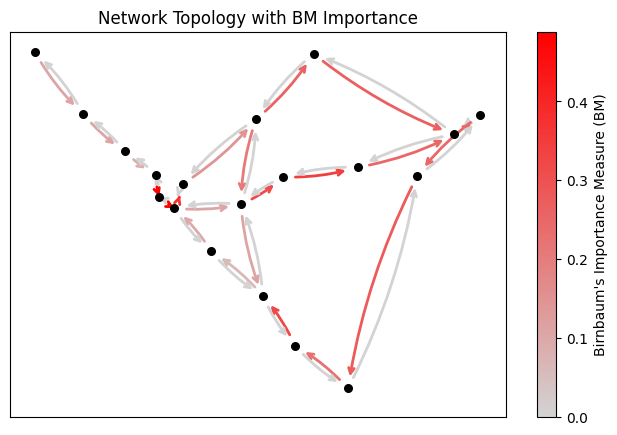

In [ ]:
# Create custom colormap from light gray to red
cmap = mpl.colors.LinearSegmentedColormap.from_list("gray_to_red", ["lightgray", "red"])

# Create NetworkX graph
G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)
for edge_name, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_distance[edge_name], label=edge_name)
pos = nx.get_node_attributes(G, "pos")

# Get min and max BM values for color scaling
BM_max = max(component_BM.values()) if max(component_BM.values()) > 0 else 1
BM_min = min(component_BM.values()) if min(component_BM.values()) > 0 else 0

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_frame_on(True)  # Ensure plot box is visible
nx.draw_networkx_nodes(G, pos, node_size=30, node_color="black", ax=ax)
drawn_edges = set()  # To avoid duplicate plotting

for edge_name, (u, v) in edges.items():
    if edge_name in drawn_edges:
        continue  # Skip if already drawn

    # Map BM values to color scale (without normalization)
    color = cmap((component_BM[edge_name] - BM_min) / (BM_max - BM_min) if BM_max != BM_min else 0.5)

    # Forward direction (u -> v)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=2,
        edge_color=[color], edge_cmap=cmap,
        arrowstyle="->", arrowsize=10,
        alpha=1, ax=ax, connectionstyle="arc3,rad=0.08"
    )

    # Reverse direction (v -> u)
    reverse_edge = bidirectional_mapping.get(edge_name, edge_name)
    if reverse_edge != edge_name:  # Ensure backward edge exists
        color_reverse = cmap((component_BM[reverse_edge] - BM_min) / (BM_max - BM_min) if BM_max != BM_min else 0.5)
        nx.draw_networkx_edges(
            G, pos, edgelist=[(v, u)], width=2,
            edge_color=[color_reverse], edge_cmap=cmap,
            arrowstyle="->", arrowsize=10,
            alpha=1, ax=ax, connectionstyle="arc3,rad=0.08"
        )

    # Mark both forward and backward edges as drawn
    drawn_edges.add(edge_name)
    drawn_edges.add(reverse_edge)

# Colorbar setup
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=BM_min, vmax=BM_max))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Birnbaum's Importance Measure (BM)")

plt.title("Network Topology with BM Importance")
plt.show()
